# Debugging for dataset
## script
    - Make sure the dataset script is in `vos/dataset/`
    - And this notebook is working on `COCO.py` or `ECSSD.py`

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from vos.utils.helpers import stack_images, stack_masks
from vos.datasets.COCO import COCO
from vos.datasets.ECSSD import ECSSD
from vos.datasets.MSRA10K import MSRA10K

In [6]:
# cocoroot = "/p300/videoObjSeg_dataset/COCO-2017-train"
# cocod = dataset = COCO(cocoroot, mode= "train", max_n_objects= 8)

# ecssdroot = "/p300/videoObjSeg_dataset/ECSSD"
# dataset = ECSSD(ecssdroot)

msraroot = "/p300/videoObjSeg_dataset/MSRA10K_Imgs_GT"
dataset = MSRA10K(msraroot)

print(len(dataset))
data = dataset[np.random.choice(len(dataset), 1)[0]]
for k, v in data.items():
    print(k, v.shape)

1000
image torch.Size([3, 328, 400])
mask torch.Size([2, 328, 400])
n_objects torch.Size([])


tensor(1.) (328, 400, 2)


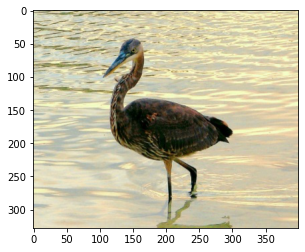

In [7]:
image = data["image"].numpy().transpose(1,2,0)
mask = data["mask"].numpy().transpose(1,2,0)

print(data["n_objects"], mask.shape)
no = data["n_objects"]
H, W, N = mask.shape
plt.imshow(image)

(328, 800)


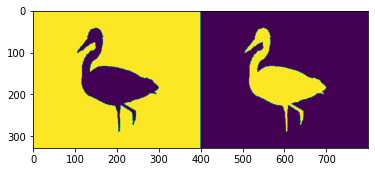

In [8]:
s_masks = stack_masks(
    np.expand_dims(mask.transpose(2,0,1), 0)
)
print(s_masks[0,0].shape)
plt.imshow(s_masks[0,0])

## Bug confirmed:
    Wrong masked in channel whose idx is greater than 1

In [ ]:
import skimage.io as io

In [ ]:
idx = np.random.choice(len(cocod), 1)[0]

img = cocod.coco.loadImgs(cocod.imgIds[idx])[0]
# This image is in (H, W, C) shape
image = io.imread('%s/images/%s'%(
    cocod._root,
    img['file_name']
)).astype(np.float32) / 255

annIds = cocod.coco.getAnnIds(imgIds= img["id"])
anns = cocod.coco.loadAnns(annIds)

anns.sort(key= lambda x: x["area"], reverse= True)

ann = anns[0]
ann_mask = cocod.coco.annToMask(ann)
H, W = ann_mask.shape
print(ann_mask.shape, type(anns))
plt.imshow(image)

In [ ]:
print(ann.keys())
print("area: {}".format(ann["area"]))
print("area fraction: {}".format(ann["area"] / np.prod(image.shape)))
plt.imshow(ann_mask, cmap= "gray")

In [ ]:
mask = np.empty((H, W, 1), dtype= np.uint8)
print((mask == 0).all())
mask[:, :, 0] |= ann_mask
plt.imshow(mask[:,:,0], cmap= "gray")

In [ ]:
mask = np.zeros((H, W, 1), dtype= np.uint8)
print((mask == 0).all())
mask[:, :, 0] |= ann_mask
plt.imshow(mask[:,:,0], cmap= "gray")